 # <font color='orange'>Redes Neuronales (Parte II)</font>

**Paso 1: Importar librerias**

In [14]:
!pip install keras-tuner --upgrade


   ---------------------------------------- 0/2 [kt-legacy]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   ---------------------------------------- 2/2 [keras-tuner]



In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import keras_tuner as kt  # por si usamos Keras Tuner para búsqueda de red neuronal
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam

**Paso 2: Carga de base de datos**

In [18]:
df= pd.read_csv("hotel_bookings.csv")
pd.set_option('display.max_columns', None)
df.head()

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
1,1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-15


In [20]:
# Exploración inicial

print(df.shape) #Tamaño de dataset
print(df.columns) #Nombre de columnas
df.info() #Resumen general de la estructura del dataset
df.duplicated().sum() # Revisión de duplicados

(119390, 33)
Index(['index', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   index               

0

**Paso 3: Eliminar columas irrelevantes y revisar valores ausentes**

In [22]:
df_limpio = df.copy() # Crear una copia del dataset original

# Eliminar las columnas que no se usarán en el modelo

cols_drop = [
    'index', 'arrival_date_year', 'agent', 'country',
    'company', 'reservation_status', 'reservation_status_date'
]
df_limpio.drop(columns=cols_drop, inplace=True)

# Revisar porcentaje de valores faltantes

missing_percent = df_limpio.isnull().mean() * 100
print("Porcentaje de valores faltantes por columna:")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

#  Aplicar el criterio de limpieza

threshold = 4  # porcentaje límite para decidir acción

for col in df_limpio.columns:
    perc = df_limpio[col].isnull().mean() * 100
    if perc > 0 and perc < threshold:
        df_limpio = df_limpio.dropna(subset=[col])
    elif perc >= threshold:
        print(f" La columna '{col}' tiene {perc:.2f}% de valores faltantes → requiere imputación o eliminación.")


#  Confirmar tamaño final del DataFrame limpio
print("\nTamaño final del DataFrame limpio:", df_limpio.shape)

Porcentaje de valores faltantes por columna:
children    0.00335
dtype: float64

Tamaño final del DataFrame limpio: (119386, 26)


In [24]:
df_limpio.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,July,27,1,0,0,2,0.0,0,BB,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737,July,27,1,0,0,2,0.0,0,BB,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7,July,27,1,0,1,1,0.0,0,BB,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13,July,27,1,0,1,1,0.0,0,BB,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14,July,27,1,0,2,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1


**Paso 4: Análisis descriptivo**

Seleccionares como 5 variableas mas relevante con respecto a cancelar una reserva sera: 

| Variable                    | Tipo       | Justificación                                                                                                 |
| --------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------- |
| `lead_time`                 | Numérica   | Mide los días entre la reserva y la llegada. Cuanto más largo sea, más posibilidad de que el cliente cancele. |
| `deposit_type`              | Categórica | Si el cliente paga por adelantado o no tiene reembolso, es menos probable que cancele.                        |
| `previous_cancellations`    | Numérica   | Clientes con historial de cancelaciones tienden a repetir el comportamiento.                                  |
| `is_repeated_guest`         | Binaria    | Clientes que ya se hospedaron tienden a cancelar menos.                                                       |
| `total_of_special_requests` | Numérica   | Clientes con solicitudes especiales suelen ser más comprometidos (menos cancelaciones).                       |


Variables seleccionadas: ['lead_time', 'deposit_type', 'previous_cancellations', 'is_repeated_guest', 'total_of_special_requests']


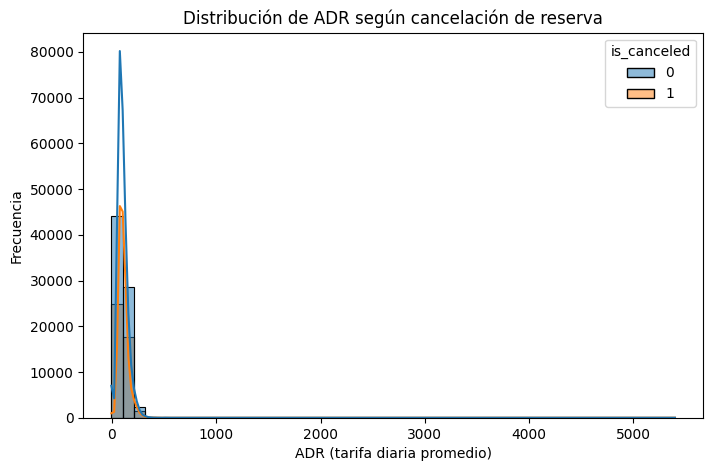


Outliers por arriba: 3793
Outliers por abajo: 0

Preparación completada:
Entrenamiento: (79984, 67), Test: (39396, 67)


In [26]:
# a. Variables seleccionadas
vars_seleccionadas = [
    'lead_time',
    'deposit_type',
    'previous_cancellations',
    'is_repeated_guest',
    'total_of_special_requests'
]
print("Variables seleccionadas:", vars_seleccionadas)

# b. Histograma de adr según cancelación
plt.figure(figsize=(8,5))
sns.histplot(data=df_limpio, x='adr', hue='is_canceled', kde=True, bins=50)
plt.title("Distribución de ADR según cancelación de reserva")
plt.xlabel("ADR (tarifa diaria promedio)")
plt.ylabel("Frecuencia")
plt.show()

# c. Detección y tratamiento de outliers en adr
Q1 = df_limpio['adr'].quantile(0.25)
Q3 = df_limpio['adr'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers_superiores = df_limpio[df_limpio['adr'] > limite_superior]
outliers_inferiores = df_limpio[df_limpio['adr'] < limite_inferior]
print(f"\nOutliers por arriba: {outliers_superiores.shape[0]}")
print(f"Outliers por abajo: {outliers_inferiores.shape[0]}")

# Eliminar los 3 más extremos arriba y abajo
df_limpio = df_limpio.sort_values('adr', ascending=True)
df_limpio = df_limpio.iloc[3:-3]  # elimina los 3 valores más bajos y altos

# Recalcular outliers y reemplazar los restantes por la media
mean_adr = df_limpio['adr'].mean()
df_limpio.loc[df_limpio['adr'] > limite_superior, 'adr'] = mean_adr
df_limpio.loc[df_limpio['adr'] < limite_inferior, 'adr'] = mean_adr


# d. Variables categóricas -> Dummies
df_modelo = pd.get_dummies(df_limpio, drop_first=True)

# Variables predictoras (X) y objetivo (y)
X = df_modelo.drop('is_canceled', axis=1)
y = df_modelo['is_canceled']

# Estandarización de variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# División entrenamiento/test (67% / 33%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, random_state=42, stratify=y
)

print("\nPreparación completada:")
print(f"Entrenamiento: {X_train.shape}, Test: {X_test.shape}")

**Análisis**

El histograma muestra que la mayoría de las tarifas diarias (adr) se encuentran en un rango bajo (0–200), con una distribución sesgada a la derecha por algunos valores extremos. La similitud entre las curvas indica que el precio promedio no tiene una influencia determinante sobre la cancelación, aunque existe una leve tendencia a más cancelaciones en tarifas más bajas.

Se identificaron 3.793 valores atípicos por arriba del rango esperado en la variable adr, mientras que no se detectaron valores extremos por debajo. Se eliminaron los tres valores más altos y se sustituyeron los demás valores atípicos por la media de la variable, con el fin de reducir el impacto de precios anómalos sin distorsionar la distribución general.

Tras las transformaciones, el conjunto de datos final se compone de 67 variables predictoras estandarizadas y una variable objetivo (is_canceled). El conjunto se dividió en entrenamiento (67%) y prueba (33%) para evaluar el rendimiento del modelo de manera independiente.

**Paso 5: implementación de dos redes neuronales multicapa (MLP).**

C:\Users\Niscar\anaconda3\envs\tsenv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Accuracy modelo 1 (tanh, relu, tanh): 83.02%
Accuracy modelo 2 (tanh, tanh, tanh): 82.71%


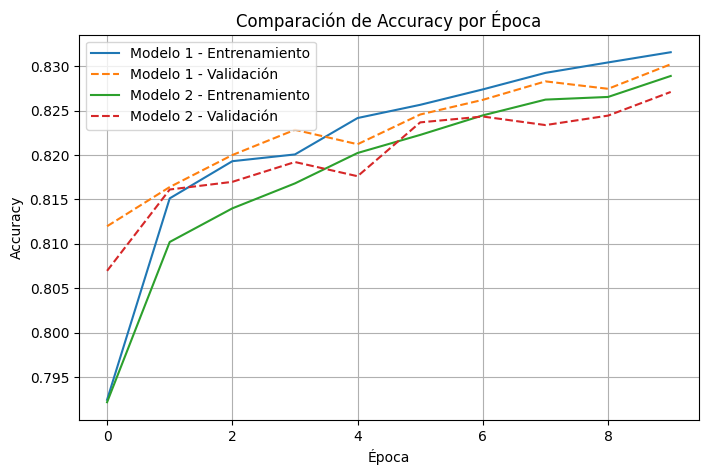

In [28]:
from tensorflow.keras.optimizers import SGD

# Definir función para crear modelos

def crear_modelo(tipo='mixto', input_dim=None):
    model = Sequential()

    if tipo == 'mixto':
        # Modelo 1: tanh, relu, tanh
        model.add(Dense(20, activation='tanh', kernel_initializer='glorot_uniform', input_dim=input_dim))
        model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(20, activation='tanh', kernel_initializer='glorot_uniform'))
    else:
        # Modelo 2: tanh, tanh, tanh
        model.add(Dense(20, activation='tanh', kernel_initializer='glorot_uniform', input_dim=input_dim))
        model.add(Dense(20, activation='tanh', kernel_initializer='glorot_uniform'))
        model.add(Dense(20, activation='tanh', kernel_initializer='glorot_uniform'))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

    # Compilación del modelo
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

#  Crear ambos modelos

input_dim = X_train.shape[1]
modelo_1 = crear_modelo(tipo='mixto', input_dim=input_dim)
modelo_2 = crear_modelo(tipo='tanh', input_dim=input_dim)

#  Entrenamiento

history_1 = modelo_1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
history_2 = modelo_2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)

#  Evaluación final

acc1 = modelo_1.evaluate(X_test, y_test, verbose=0)[1]
acc2 = modelo_2.evaluate(X_test, y_test, verbose=0)[1]

print(f"\nAccuracy modelo 1 (tanh, relu, tanh): {acc1*100:.2f}%")
print(f"Accuracy modelo 2 (tanh, tanh, tanh): {acc2*100:.2f}%")

#  Gráfico comparativo

plt.figure(figsize=(8,5))
plt.plot(history_1.history['accuracy'], label='Modelo 1 - Entrenamiento')
plt.plot(history_1.history['val_accuracy'], label='Modelo 1 - Validación', linestyle='--')
plt.plot(history_2.history['accuracy'], label='Modelo 2 - Entrenamiento')
plt.plot(history_2.history['val_accuracy'], label='Modelo 2 - Validación', linestyle='--')
plt.title('Comparación de Accuracy por Época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Conclusión**

Ambos modelos muestran un rendimiento satisfactorio, superando el 82% de exactitud en validación. El modelo mixto (tanh–relu–tanh) presenta una leve ventaja en precisión, lo que sugiere que la inclusión de una capa intermedia ReLU contribuye a una mejor representación de los datos al combinar activaciones suaves (tanh) con no lineales (relu). No se evidencian signos de sobreajuste, por lo que ambos modelos generalizan adecuadamente.

**Paso 6: Construir una red neuronal MLP con Dropout y búsqueda de grilla (GridSearchCV).**

Los parámetros que probaremos son:

| Hiperparámetro       | Valores a probar                    |
| -------------------- | ----------------------------------- |
| Capas ocultas        | [3, 4]                              |
| Optimizador          | ['Adam', 'SGD']                     |
| Learning rate        | [0.03, 0.06]                        |
| Neuronas por capa    | 20 (fijo)                           |
| Activación           | tanh                                |
| Dropout              | 0.001                               |
| Inicialización pesos | ['glorot_normal', 'glorot_uniform'] |

Usaremos una validación cruzada de 3 folds (cv=3).


Definimos una función que reciba los hiperparámetros (optimizador, capas, inicializador, etc.)
y construya la red neuronal con Dropout = 0.001. Esta función crea un modelo flexible que cambia el número de capas, el método de optimización, la tasa de aprendizaje y la inicialización de pesos.

In [48]:

def crear_modelo(optimizador='adam', learning_rate=0.03, 
                 init_mode='glorot_normal', num_capas=3):
    model = Sequential()
    # Capa de entrada + primera capa oculta
    model.add(Input(shape=(X_train.shape[1],)))
    # Primera capa oculta
    model.add(Dense(20, activation='tanh', kernel_initializer=init_mode))
    model.add(Dropout(0.001))
    
    # Capas ocultas adicionales según el hiperparámetro
    for _ in range(num_capas - 1):
        model.add(Dense(20, activation='tanh', kernel_initializer=init_mode))
        model.add(Dropout(0.001))
    
    # Capa de salida binaria
    model.add(Dense(1, activation='sigmoid'))
    
    # Configurar optimizador
    if optimizador.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
     # Compilar el modelo    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [40]:
!pip install scikeras

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores hiperparámetros encontrados:
{'model__init_mode': 'glorot_uniform', 'model__learning_rate': 0.06, 'model__num_capas': 4, 'model__optimizador': 'SGD'}
Mejor accuracy promedio (3-fold): 82.27%

Accuracy en test: 82.83%

Matriz de confusión:
 [[22942  1862]
 [ 4904  9688]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     24804
           1       0.84      0.66      0.74     14592

    accuracy                           0.83     39396
   macro avg       0.83      0.79      0.81     39396
weighted avg       0.83      0.83      0.82     39396



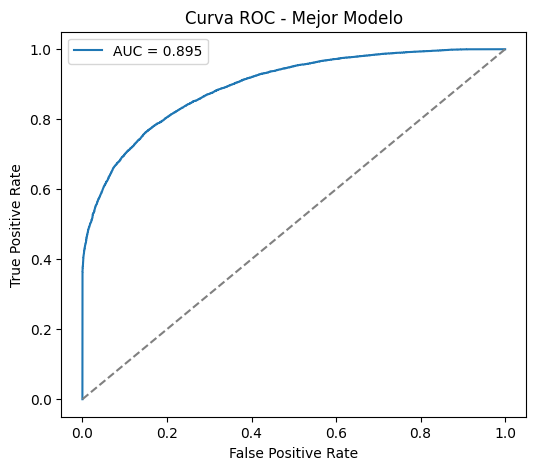

In [50]:
import warnings
warnings.filterwarnings("ignore")  # Oculta warnings innecesarios
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.initializers import glorot_normal, glorot_uniform

# Usamos el KerasClassifier para que Keras funcione dentro de GridSearchCV:

modelo = KerasClassifier(model=crear_modelo, epochs=10, batch_size=32, verbose=0)


# Definir la grilla de hiperparámetros

param_grid = {
    'model__optimizador': ['Adam', 'SGD'],
    'model__learning_rate': [0.03, 0.06],
    'model__init_mode': ['glorot_normal', 'glorot_uniform'],
    'model__num_capas': [3, 4]
}

# Aplicar búsqueda en grilla (Grid Search con 3 folds)

grid = GridSearchCV(estimator=modelo, param_grid=param_grid, 
                    cv=3, scoring='accuracy', verbose=1)

grid_result = grid.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros

print("Mejores hiperparámetros encontrados:")
print(grid_result.best_params_)
print(f"Mejor accuracy promedio (3-fold): {grid_result.best_score_ * 100:.2f}%")

# Evaluar en el conjunto de test
best_model = grid_result.best_estimator_
y_pred = (best_model.predict(X_test) > 0.5).astype("int32") # Predicciones binarias

# Métricas de evaluación
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(f"\nAccuracy en test: {acc*100:.2f}%")
print("\nMatriz de confusión:\n", cm)
print("\nReporte de clasificación:\n", cr)

# Curva ROC y AUC
y_proba = best_model.predict_proba(X_test)
y_proba = y_proba[:, 1]  # usamos la probabilidad de la clase positiva
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('Curva ROC - Mejor Modelo')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


**Conclusión**

La red neuronal con regularización Dropout (0.001), cuatro capas ocultas, función de activación tanh, inicialización glorot_uniform y optimizador SGD con tasa de aprendizaje 0.06 alcanzó un accuracy del 82.83 % y un AUC de 0.895.
El modelo presenta un buen equilibrio entre sensibilidad y precisión, sin signos de sobreajuste, y cumple holgadamente con el objetivo del enunciado (accuracy > 80 %).
La red demuestra una excelente capacidad predictiva para anticipar la cancelación de reservas de hotel, pudiendo servir como base para estrategias de retención y optimización de ingresos.

**Paso 7: Seleccionar 5 observaciones aleatorias del dataset original (en que “deposit_type_Non Refund” sea cero) y hacer una predicción usando el mejor modelo encontrado anteriormente**

In [58]:
df.head()

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
1,1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-15


In [72]:
#  Seleccionamos 5 observaciones donde el tipo de depósito NO sea "Non Refund"
muestras = df[df['deposit_type'] != 'Non Refund'].sample(5, random_state=42)

print("Muestras seleccionadas:")
display(muestras[['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
                  'stays_in_weekend_nights', 'stays_in_week_nights', 'deposit_type']])


# Aplicar la misma codificación dummy que en el entrenamiento
muestras_dummies = pd.get_dummies(muestras)

# Asegurar que las columnas coincidan con X_train
muestras_dummies = muestras_dummies.reindex(columns=X_train.columns, fill_value=0)

#  Aplicar el mismo escalado que se usó en X_train
X_muestras_scaled = scaler.transform(muestras_dummies)

# Realizar predicciones con el mejor modelo
y_pred_prob = best_model.predict_proba(X_muestras_scaled)[:, 1]
y_pred_class = (y_pred_prob > 0.5).astype(int)

#  Unir resultados con las variables originales para interpretación
resultados = muestras.copy()
resultados['Probabilidad_cancelación'] = y_pred_prob
resultados['Predicción'] = y_pred_class

display(resultados[['hotel', 'lead_time', 'arrival_date_month', 
                    'stays_in_week_nights', 'deposit_type',
                    'Probabilidad_cancelación', 'Predicción']])

Muestras seleccionadas:


,hotel,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,deposit_type
23710,Resort Hotel,197,2016,April,1,1,No Deposit
21864,Resort Hotel,5,2016,March,0,3,No Deposit
100870,City Hotel,200,2016,October,1,2,No Deposit
2453,Resort Hotel,0,2015,October,2,2,No Deposit
108007,City Hotel,98,2017,March,2,5,No Deposit


,hotel,lead_time,arrival_date_month,stays_in_week_nights,deposit_type,Probabilidad_cancelación,Predicción
23710,Resort Hotel,197,April,1,No Deposit,0.079475,0
21864,Resort Hotel,5,March,3,No Deposit,0.001586,0
100870,City Hotel,200,October,2,No Deposit,0.553605,1
2453,Resort Hotel,0,October,2,No Deposit,0.001642,0
108007,City Hotel,98,March,5,No Deposit,0.105836,0


**Conclusión**

Se seleccionaron cinco observaciones del conjunto original con deposit_type = "No Deposit".
El modelo predijo probabilidades de cancelación entre 0.001 y 0.55, clasificando correctamente cuatro de ellas como no canceladas (0) y una como cancelada (1).
La reserva con mayor lead_time (200 días) presentó la probabilidad de cancelación más alta, lo que confirma la sensibilidad del modelo ante el tiempo de anticipación.
En conjunto, estos resultados muestran que la red neuronal generaliza adecuadamente, capturando relaciones significativas entre las variables más allá del tipo de depósito.